In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

<h1>PREPARING DATA</h1>

<h4>0. Input Data</h4>

In [2]:
df = pd.read_excel('input\DS.xlsx')
df.head()

,MQ2,MQ3,MQ4,MQ5,MQ6,MQ7,MQ8,MQ9,MQ135,SPAD,Nitrogen,Flavonoid
0,0.32,0.17,0.49,0.20,0.17,0.14,0.14,0.22,0.17,00SPAD,01N,00F
1,0.30,0.20,0.51,0.17,0.17,0.14,0.10,0.22,0.17,00SPAD,01N,00F
2,0.28,0.20,0.45,0.20,0.17,0.14,0.10,0.22,0.14,00SPAD,01N,00F
3,0.30,0.20,0.48,0.20,0.17,0.14,0.10,0.22,0.17,00SPAD,01N,00F
4,0.32,0.20,0.48,0.20,0.17,0.14,0.10,0.22,0.17,00SPAD,01N,00F


In [3]:
df.drop(['Flavonoid', 'Nitrogen'], axis=1, inplace=True)

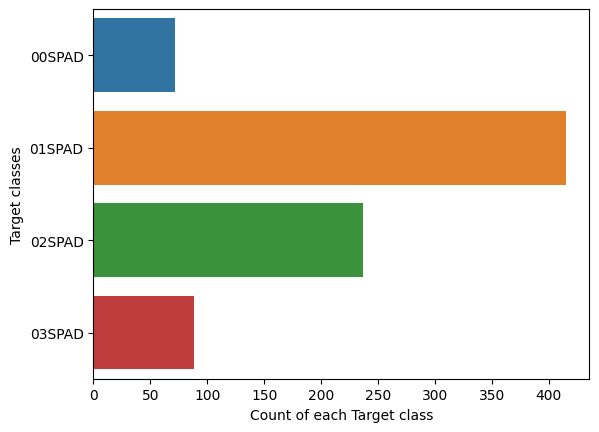

In [4]:
sns.countplot(y=df.SPAD, data=df)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

<h4>1. Membagi Data untuk Training dan Testing</h4>

In [5]:
X = df.drop(['SPAD'], axis=1)
y = df.SPAD
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

<h4>2. Standarisasi Data</h4>

In [6]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


<h1>METODE 1: KNN</h1>

In [7]:
from sklearn.neighbors import KNeighborsClassifier

<h4>1. Menentukan Nilai k</h4>


The optimal number of neighbors is 11.


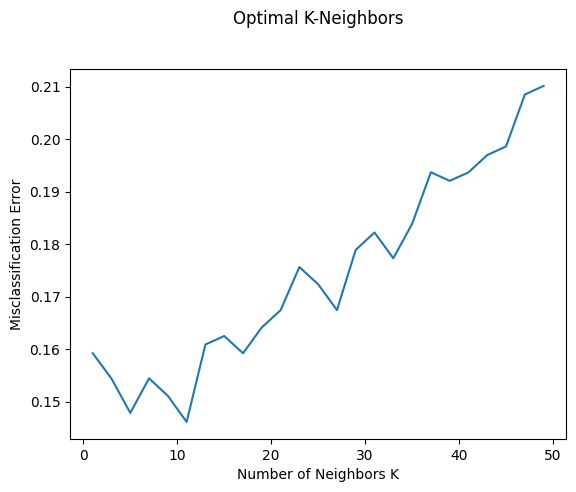

In [8]:
myList = list(range(0, 50))
neighbors = list(filter(lambda x : x % 2 != 0, myList))
neighbors
cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy' )
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)
plt.title('Optimal K-Neighbors', y=1.1)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

<h4>2. Tune KNN</h4>

In [9]:
clf = KNeighborsClassifier(metric= 'euclidean', n_neighbors= optimal_k)
clf.fit(X_train, y_train)

y_pred_knn = clf.predict(X_test)
pd.crosstab(y_test, y_pred_knn)

cm = confusion_matrix(y_test, y_pred_knn)
accuracy = accuracy_score(y_test, y_pred_knn)*100
print("Accuracy with K-NN: {0:.2f}%".format(accuracy))


Accuracy with K-NN: 88.18%


<h1>METODE 2 : SVM</h1>

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from transformers import pipeline

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


<h4>1. Menentukan Parameter Terbaik</h4>

In [11]:
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=8)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    }

gridSearch = GridSearchCV(SVC(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...........................gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............................gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........................gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ..........................gamma=auto, kernel=linear; total time=   0.0s
[CV] END ............................gamma=auto, kernel=poly; total time=   0.0s
[CV] END .............................gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........................gamma=auto, kernel=sigmoid; total time=   0.0s
Score:  nan
Parameters:  {'gamma': 'scale', 'kernel': 'linear'}


<h4>2. Tune SVM</h4>

In [12]:
svm = make_pipeline(StandardScaler(), SVC(gamma='scale', kernel='linear'))
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
pd.crosstab(y_test, y_pred_svm)

cm = confusion_matrix(y_test, y_pred_svm)
accuracy = accuracy_score(y_test, y_pred_svm)*100
print("Accuracy with SVM: {0:.2f}%".format(accuracy))


Accuracy with SVM: 80.79%


<h1>METODE 3: Decission Trees (dt)</h1>

In [13]:
from sklearn.tree import DecisionTreeClassifier

<h4>1. Menentukan Parameter Terbaik</h4>

In [14]:
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=8)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    }

gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END ..................................criterion=entropy; total time=   0.0s
[CV] END .................................criterion=log_loss; total time=   0.0s
Score:  nan
Parameters:  {'criterion': 'gini'}


<h4>2. Tune DT</h4>

In [15]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
pd.crosstab(y_test, y_pred_dt)

cm = confusion_matrix(y_test, y_pred_dt)
accuracy = accuracy_score(y_test, y_pred_dt)*100
print("Accuracy with DTC: {0:.2f}%".format(accuracy))


Accuracy with DTC: 86.21%


<h4>>>>> Visualisasi</h4>

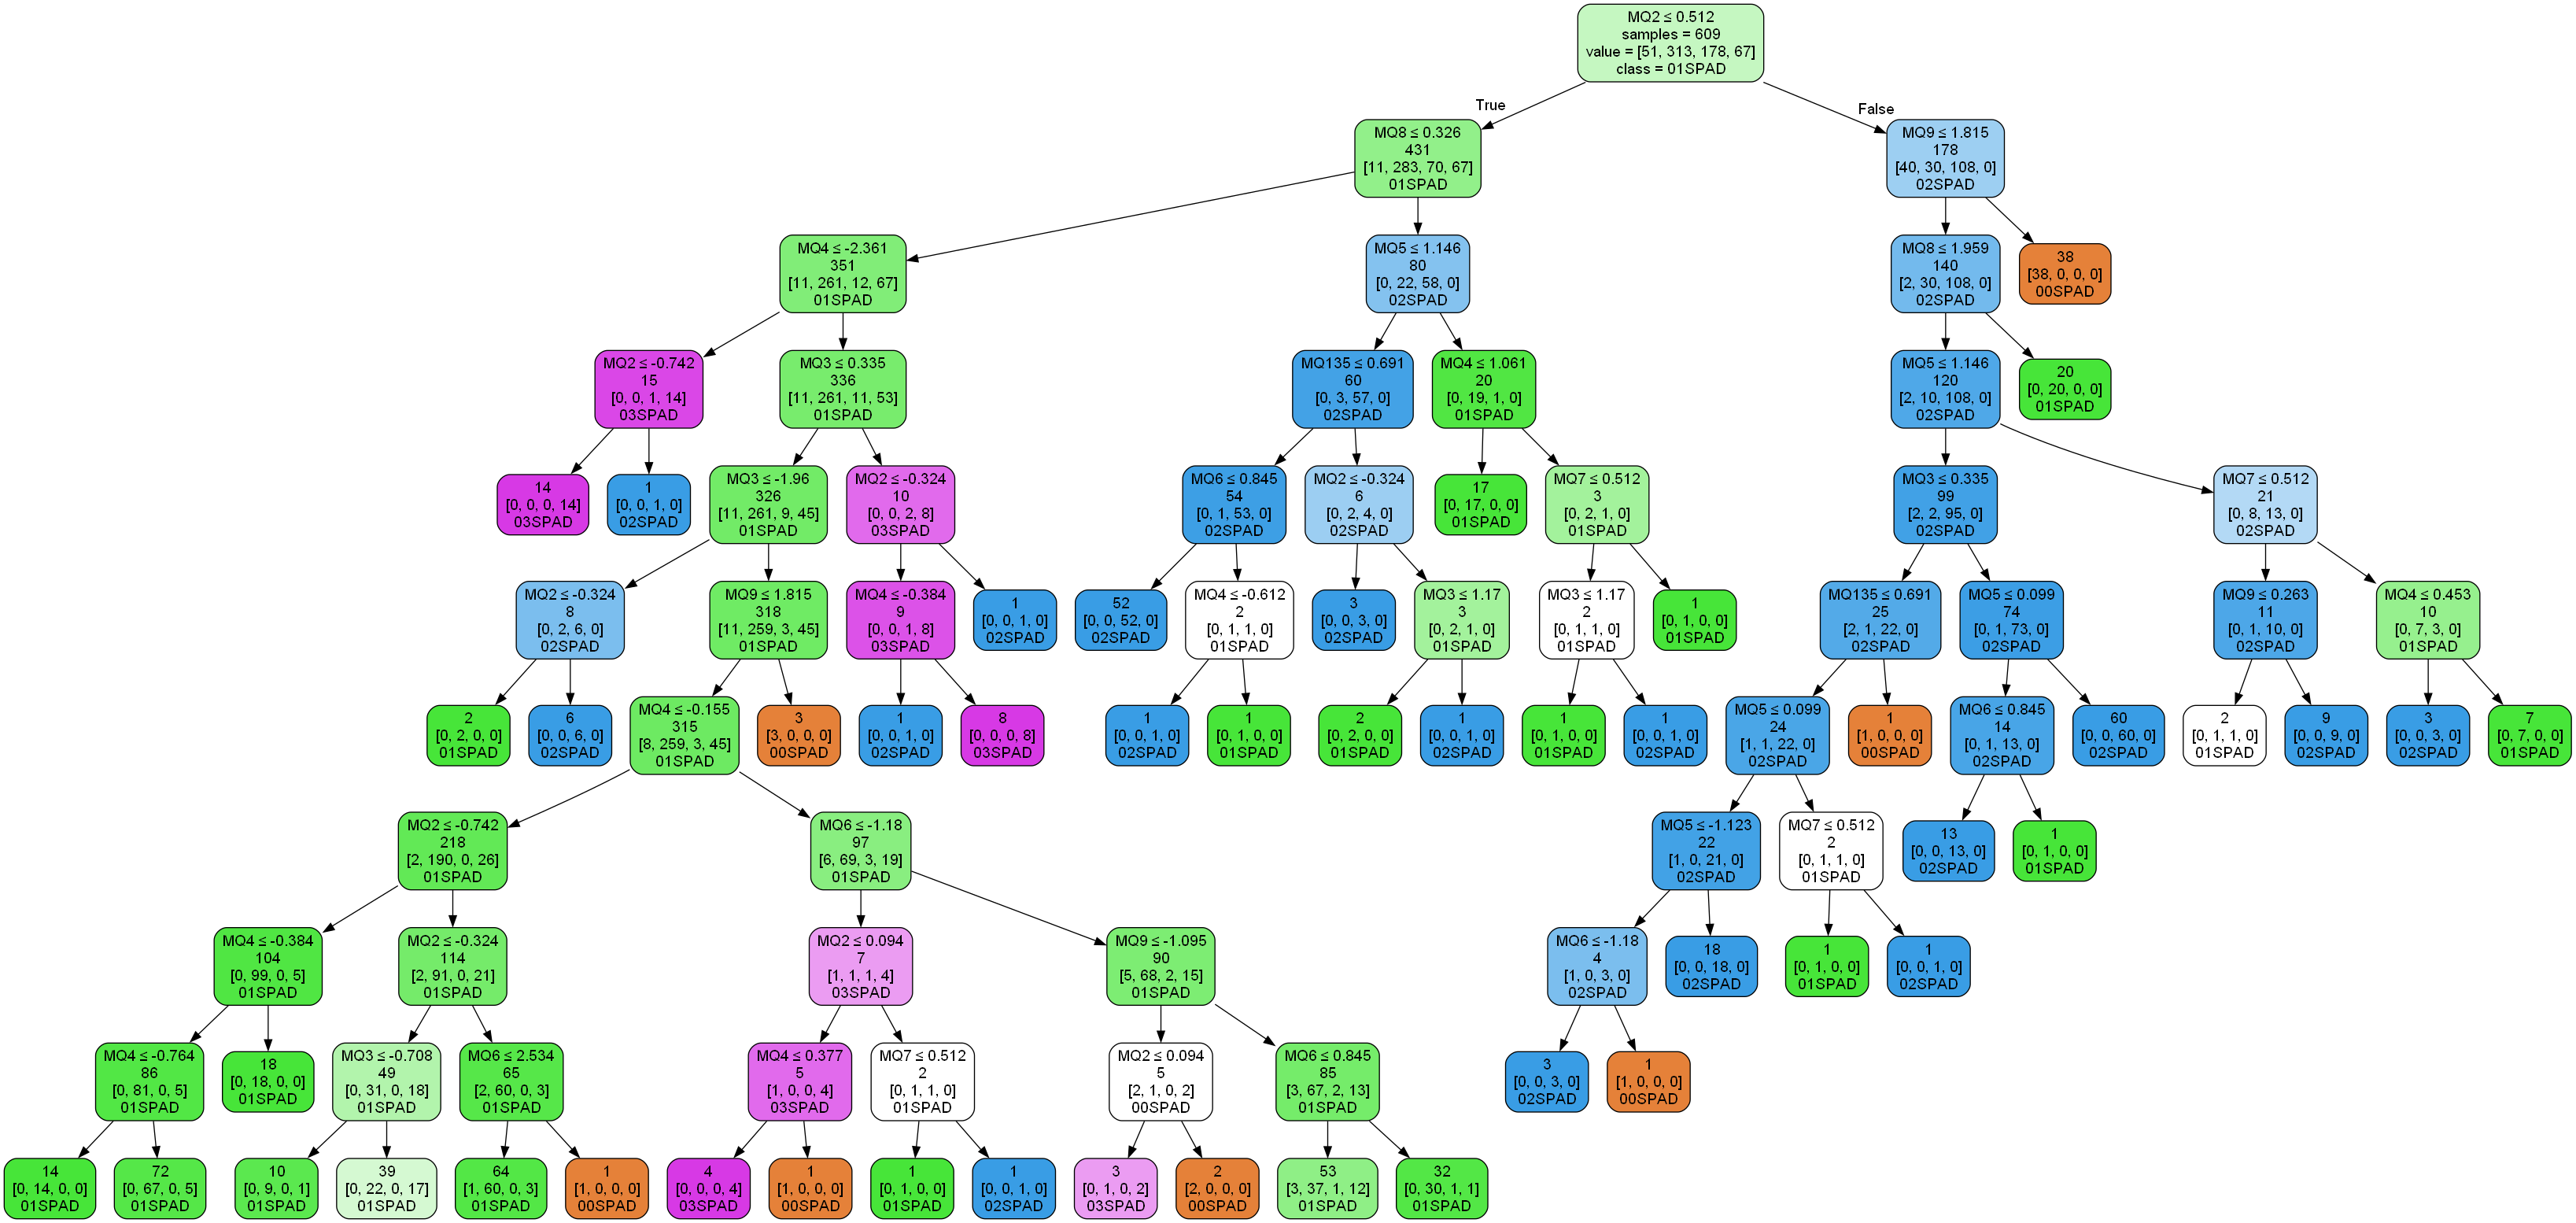

In [16]:
from dmba import plotDecisionTree
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

plotDecisionTree(dt, feature_names=X_train.columns, class_names=dt.classes_)

<h4>1. Preprocessing</h4>

<h1>METODE 4: Multilayer Perceptron (mlp)</h1>

In [17]:
from sklearn.neural_network import MLPClassifier

<h4>1. Menentukan parameter terbaik</h4>

In [18]:
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=8)

param_grid = {
    'activation': ['identity','logistic','tanh','relu'],
    'solver': ['lbfgs','sgd','adam']
    }

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.1s
[CV] END ....................activation=identity, solver=sgd; total time=   0.5s
[CV] END ...................activation=identity, solver=adam; total time=   0.5s
[CV] END ..................activation=logistic, solver=lbfgs; total time=   1.4s
[CV] END ....................activation=logistic, solver=sgd; total time=   1.4s
[CV] END ...................activation=logistic, solver=adam; total time=   1.5s
[CV] END ......................activation=tanh, solver=lbfgs; total time=   0.6s
[CV] END ........................activation=tanh, solver=sgd; total time=   0.7s
[CV] END .......................activation=tanh, solver=adam; total time=   0.6s
[CV] END ......................activation=relu, solver=lbfgs; total time=   0.5s
[CV] END ........................activation=relu, solver=sgd; total time=   0.6s
[CV] END .......................activation=relu,

<h4>2. Tune MLP</h4>

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=10,activation='identity', solver='lbfgs', max_iter=1000,
                            random_state=8)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

cm = confusion_matrix(y_test, y_pred_mlp)
accuracy = accuracy_score(y_test, y_pred_mlp)*100
print("Accuracy with MLP: {0:.2f}%".format(accuracy))

Accuracy with MLP: 78.82%


<h1>COMPARING METHODE</h1>

In [20]:
print("----------------------------MLP-----------------------------------------")
print(classification_report(y_test, y_pred_mlp))
cm = confusion_matrix(y_test, y_pred_mlp)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_mlp, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_mlp, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_mlp, average='macro')))

print("----------------------------DT-----------------------------------------")
print(classification_report(y_test, y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_dt, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_dt, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_dt, average='macro')))

print("----------------------------SVM-----------------------------------------")
print(classification_report(y_test, y_pred_svm))
cm = confusion_matrix(y_test, y_pred_svm)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_svm, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_svm, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_svm, average='macro')))

print("----------------------------KNN-----------------------------------------")
print(classification_report(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_knn, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_knn, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_knn, average='macro')))

----------------------------MLP-----------------------------------------
              precision    recall  f1-score   support

      00SPAD       0.95      0.90      0.93        21
      01SPAD       0.76      0.89      0.82       102
      02SPAD       0.78      0.80      0.79        59
      03SPAD       0.75      0.14      0.24        21

    accuracy                           0.79       203
   macro avg       0.81      0.68      0.70       203
weighted avg       0.79      0.79      0.76       203

Recall:0.68
Precision:0.81
F1-Score:0.70
----------------------------DT-----------------------------------------
              precision    recall  f1-score   support

      00SPAD       1.00      0.95      0.98        21
      01SPAD       0.81      0.96      0.88       102
      02SPAD       0.95      0.88      0.91        59
      03SPAD       0.71      0.24      0.36        21

    accuracy                           0.86       203
   macro avg       0.87      0.76      0.78       203

Text(0.5, 41.90882444583199, 'PREDIKSI')

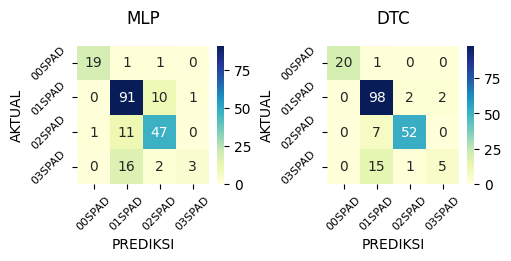

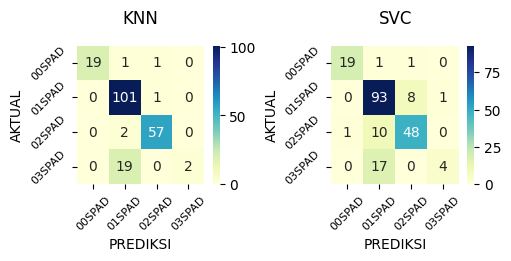

In [21]:
plt.figure(figsize=(5,2.5), layout="constrained")


plt.subplot(1,2,1)
p = sns.heatmap(pd.crosstab(y_test, y_pred_mlp), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('MLP', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')

plt.subplot(1,2,2)
p = sns.heatmap(pd.crosstab(y_test, y_pred_dt), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('DTC', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')


plt.figure(figsize=(5,2.5), layout="constrained")
plt.subplot(1,2,1)
p = sns.heatmap(pd.crosstab(y_test, y_pred_knn), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('KNN', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')

plt.subplot(1,2,2)
p = sns.heatmap(pd.crosstab(y_test, y_pred_svm), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('SVC', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')